In [1]:
# 格式解析和转换
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import os, json, cv2
import numpy as np


def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


for d in ["train", "val"]:
    DatasetCatalog.register(
        "balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d)
    )
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")


/home/public_1/develop/Anaconda3/envs/detectron2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


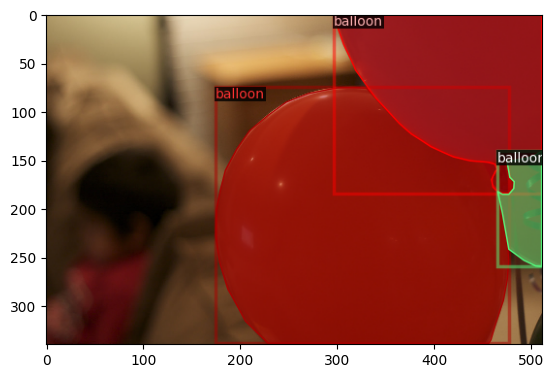

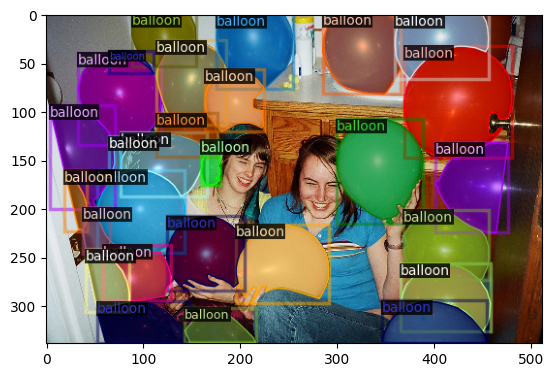

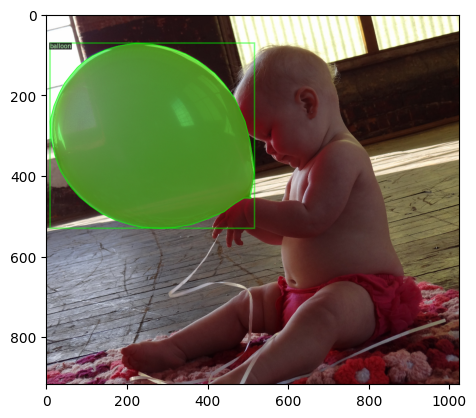

In [2]:
# 可视化处理后的数据
from detectron2.utils.visualizer import Visualizer
import random
from PIL import Image
import matplotlib.pyplot as plt


dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    # 使用plt.figure()显示多幅图片
    plt.figure()
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # 上面的Visualizer已经处理好了RGB通道，不需要再交换了
    plt.imshow(out.get_image())


In [3]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo


cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# 使用预训练权重初始化训练
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
# 设置batch_size
cfg.SOLVER.IMS_PER_BATCH = 2
# 设置学习率
cfg.SOLVER.BASE_LR = 0.00025
# 设置迭代iteration次数(注意是迭代多少张图片，不是epoch)
cfg.SOLVER.MAX_ITER = 300
# 不衰减学习率
cfg.SOLVER.STEPS = []
# “RoIHead batch size”。128速度更快，并且足够适合这个简单数据集（默认值：512）
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# 分类的数量，这里只有一类（气球）
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[09/24 21:58:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[09/24 21:58:02 d2.engine.train_loop]: Starting training from iteration 0


/home/public_1/develop/Anaconda3/envs/detectron2/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/24 21:58:15 d2.utils.events]:  eta: 0:02:11  iter: 19  total_loss: 1.895  loss_cls: 0.5468  loss_box_reg: 0.6327  loss_mask: 0.6893  loss_rpn_cls: 0.01916  loss_rpn_loc: 0.005286  time: 0.4753  data_time: 0.0166  lr: 1.6068e-05  max_mem: 2416M
[09/24 21:58:25 d2.utils.events]:  eta: 0:02:06  iter: 39  total_loss: 1.66  loss_cls: 0.4878  loss_box_reg: 0.5836  loss_mask: 0.6044  loss_rpn_cls: 0.03185  loss_rpn_loc: 0.0124  time: 0.4828  data_time: 0.0035  lr: 3.2718e-05  max_mem: 2416M
[09/24 21:58:35 d2.utils.events]:  eta: 0:01:56  iter: 59  total_loss: 1.558  loss_cls: 0.4076  loss_box_reg: 0.7003  loss_mask: 0.4731  loss_rpn_cls: 0.03442  loss_rpn_loc: 0.005965  time: 0.4821  data_time: 0.0032  lr: 4.9367e-05  max_mem: 2416M
[09/24 21:58:45 d2.utils.events]:  eta: 0:01:47  iter: 79  total_loss: 1.433  loss_cls: 0.3448  loss_box_reg: 0.6937  loss_mask: 0.359  loss_rpn_cls: 0.03088  loss_rpn_loc: 0.007461  time: 0.4862  data_time: 0.0034  lr: 6.6017e-05  max_mem: 2416M
[09/24 21:58

In [4]:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 13208), started 6:38:35 ago. (Use '!kill 13208' to kill it.)

In [5]:
# 使用经过训练的模型进行推断和评估


In [9]:
from detectron2.engine import DefaultPredictor


# 使用配置和训练中使用的参数进行推理
# cfg现在已经包含了之前设置的所有内容。为了推理，对它做一点修改：
# 加载训练后保存好的权重
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# 设置自定义测试阈值
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)


[09/24 22:42:37 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

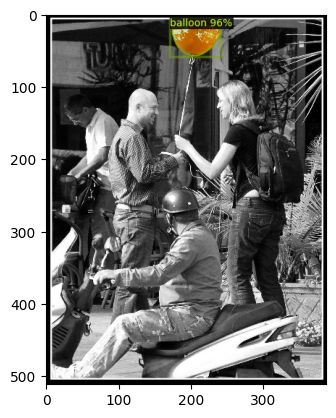

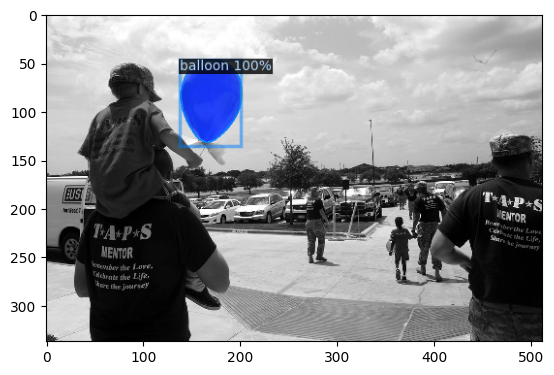

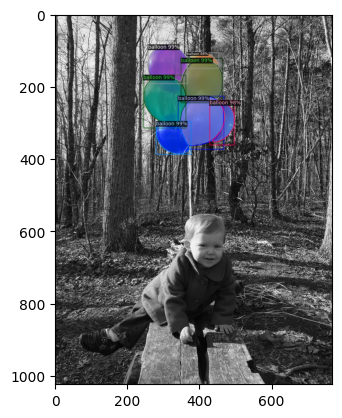

In [7]:
# 随机选择几个样本来可视化预测结果
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):
    plt.figure()
    im = cv2.imread(d["file_name"])
    outputs = predictor(
        im
    )  # 在 https://detectron2.readthedocs.io/tutorials/models.html#model-output-format查看格式
    v = Visualizer(
        im[:, :, ::-1],
        metadata=balloon_metadata,
        scale=0.5,
        instance_mode=ColorMode.IMAGE_BW,  # 删除未分割片段像素的颜色。此选项仅适用于分割模型
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])


In [8]:
# 使用COCOAPI中实现的AP评价指标来评估其性能
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("balloon_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# 评估模型的另一种等效方法是使用"trainer.test"


[09/24 22:00:37 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[09/24 22:00:37 d2.evaluation.coco_evaluation]: Trying to convert 'balloon_val' to COCO format ...
WARNING [09/24 22:00:37 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/balloon_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[09/24 22:00:37 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[09/24 22:00:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/24 22:00:37 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[09/24 22:00:37 d2.data.common]: Serialized dataset takes 0.04 MiB
[09/24 22:00:37 d2.evaluatio